# 3D Mesh to heightmap converter

Author: Beherith mysterme@gmail.com

This takes an obj file and bakes it along the Y axis

The obj mesh is scaled to the desired resolution.

Can be slow for large resolutions

Does not do smoothing


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

## Functions

In [2]:
def load_obj(filename):
    vertices = []
    faces = []

    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('v '):  # Vertex definition
                _, x, y, z = line.split()
                vertices.append([float(x), float(y), float(z)])
            elif line.startswith('f '):  # Face definition
                _, *face_vertices = line.split()
                # Convert vertex references to 0-based index
                face = [int(vertex.split('/')[0]) - 1 for vertex in face_vertices]
                faces.append(face)

    return vertices, faces

def print_face_vertices(vertices, faces):
    for face in faces:
        face_vertices = [vertices[index] for index in face]
        print(f"Face vertices: {face_vertices}")


def sign(p1, p2, p3):
    return (p1[0] - p3[0]) * (p2[2] - p3[2]) - (p2[0] - p3[0]) * (p1[2] - p3[2])

def point_inside_triangle(pt, v1, v2, v3):
    """
    Determines if a point is inside a 2D triangle.

    Parameters:
    - pt: The point to check (tuple/list of x, y coordinates).
    - v1, v2, v3: Vertices of the triangle (each is a tuple/list of x, y coordinates).

    Returns:
    - True if the point is inside the triangle, False otherwise.
    """
    d1 = sign(pt, v1, v2)
    d2 = sign(pt, v2, v3)
    d3 = sign(pt, v3, v1)

    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)

    return not (has_neg and has_pos)


def compute_plane_from_vertices(v1, v2, v3):
    """
    Computes the plane equation coefficients A, B, C, D from three vertices defining a triangle.

    Parameters:
    - v1, v2, v3: Vertices of the triangle (each is a tuple or list of x, y, z coordinates)

    Returns:
    - A tuple containing the coefficients (A, B, C, D) of the plane equation Ax + By + Cz + D = 0
    """

    # Convert vertices to NumPy arrays for vector arithmetic
    v1, v2, v3 = np.array(v1), np.array(v2), np.array(v3)

    # Compute two vectors that lie on the plane
    vector1 = v2 - v1
    vector2 = v3 - v1

    # Compute the cross product of these vectors to get a normal vector to the plane
    normal_vector = np.cross(vector1, vector2)

    # The components of the normal vector are the coefficients A, B, C
    A, B, C = normal_vector

    # Compute D using the plane equation Ax + By + Cz + D = 0 and one of the vertices (v1)
    D = -np.dot(normal_vector, v1)

    return A, B, C, D

'''
# Example usage
v1 = (1, 2, 3)
v2 = (4, 5, 6)
v3 = (7, 8, 9)

plane_coeffs = compute_plane_from_vertices(v1, v2, v3)
print(f"Plane coefficients: A={plane_coeffs[0]}, B={plane_coeffs[1]}, C={plane_coeffs[2]}, D={plane_coeffs[3]}")

for face in faces:
    face_vertices = [vertices[index] for index in face]
    
    print(f"Face vertices: {face_vertices}")
    plane_coeffs = compute_plane_from_vertices(face_vertices[0], face_vertices[1], face_vertices[2])
    print(f"Plane coefficients: A={plane_coeffs[0]}, B={plane_coeffs[1]}, C={plane_coeffs[2]}, D={plane_coeffs[3]}")
'''


def save_as_16_bit_png(array, filename):
    """
    Saves a 2D NumPy array as a 16-bit single-channel PNG image.

    Parameters:
    - array: 2D NumPy array to be saved.
    - filename: File path or name where the image will be saved.
    """
    # Ensure the array is in 16-bit integer format
    min_val = np.min(array)
    max_val = np.max(array)
    scaled_array = (array - min_val) / (max_val - min_val) * 65535
    array_16_bit = scaled_array.astype(np.uint16)
    
    # Save the array as a PNG image
    imageio.imwrite(filename, array_16_bit, format='png')

## Main Code

In [3]:
def BakeObjToHeightMap(filename, xrez = 1024, zrez = 1024, extents = None):
    vertices, faces = load_obj(filename)
    #print_face_vertices(vertices, faces)

    ## bake shit
    mh = np.zeros((xrez,zrez))
    xs = [v[0] for v in vertices]
    zs = [v[2] for v in vertices]
    xmin = min(xs)
    xmax = max(xs)
    zmin = min(zs)
    zmax = max(zs)
    if extents:
        xmin = extents[0]
        xmax = extents[1]
        zmin = extents[2]
        zmax = extents[3]
    print (f"x = [{xmin}, {xmax}]")
    print (f"z = [{zmin}, {zmax}]")

    def w2i(x,z):
        wx = int(((x - xmin)/(xmax-xmin)) * xrez) 
        wz = int(((z - zmin)/(zmax-zmin)) * zrez)
        return wx,wz
    def transformverts(vs):
        nv = []
        for v in vs:
            vtx, vtz = w2i(v[0], v[2])
            nv.append([vtx, v[1], vtz])
        return nv


    vt = transformverts(vertices)

    for face in faces:
        fv = [vt[index] for index in face]
        #print( fv[0][0], fv[0][2])
        bbl = min([v[0] for v in fv])
        bbr = max([v[0] for v in fv]) 
        bbb = min([v[2] for v in fv])
        bbt = max([v[2] for v in fv])
        #bbl, bbt = w2i(bbl, bbt)
        #bbr, bbb = w2i(bbr, bbb)
        #  Ax + By + Cz + D = 0 
        # y = -1 *(Ax - Cz + D)/ B 
        A, B, C, D = compute_plane_from_vertices(fv[0],fv[1],fv[2])
        tltri = False
        xmean =  (fv[0][0] + fv[1][0] + fv[2][0]) / 3.0
        if xmean < (bbl + bbr) * 0.5:
            tltri = True
        dx = 0 
        for x in range(bbl, bbr):
            zl = bbb
            zr = bbt
            dz = 0
            for z in range(zl, zr):
                if not point_inside_triangle((x,0,z), fv[0], fv[1],fv[2]):
                    continue
                if tltri:
                    if dz > dx:
                        #continue
                        pass
                else:
                    if dz < dx:
                        #continue
                        pass
                if B != 0:
                    y = -1.0 * (A * x + C * z + D) / B
                    if x < xrez and z < zrez and z >=0 and z >= 0:
                        mh[x,z] = max(mh[x,z],y)
                #print(f"x = {x}, y = {y}")
                #y = ?
                # y = 
                pass
                dz += 1
            dx +=1
    plt.imshow(mh)
    plt.colorbar()
    plt.show()

    def save_as_16_bit_png(array, filename):
        """
        Saves a 2D NumPy array as a 16-bit single-channel PNG image.

        Parameters:
        - array: 2D NumPy array to be saved.
        - filename: File path or name where the image will be saved.
        """
        # Ensure the array is in 16-bit integer format
        min_val = np.min(array)
        max_val = np.max(array)
        scaled_array = (array - min_val) / (max_val - min_val) * 65535
        array_16_bit = scaled_array.astype(np.uint16)
        
        # Save the array as a PNG image
        imageio.imwrite(filename, array_16_bit, format='png')
        array_16_bit = np.swapaxes(array_16_bit,0,1)
        imageio.imwrite(filename+'swapaxes.png', array_16_bit, format='png')

    save_as_16_bit_png(mh, filename+".png")

## Usage

x = [-16, 16]
z = [-16, 16]


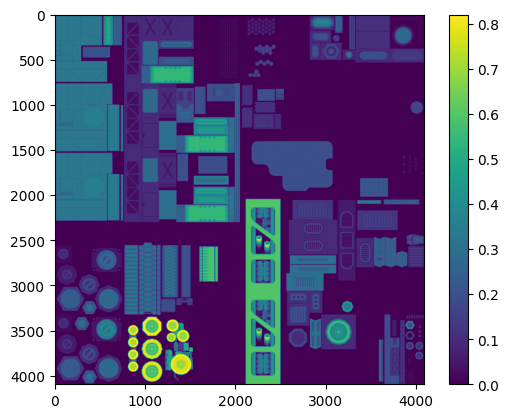

In [4]:

BakeObjToHeightMap("BAR_Legion7h1_height.obj", 8192, 8192, extents = [-16, 16, -16, 16])